In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Raw file

In [12]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


**Create the module**

In [13]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [14]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [15]:
batch_size = 60
iris_data_file = 'data/iris.data.txt'

In [16]:
# Get the datasets
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [17]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

In [18]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

    print ('Epoch %d/%d, Train Loss: %.4f'%(epoch+1, num_epochs, loss.data[0]))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.data[0])

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.data[0])
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Train Loss: 1.0752
Epoch 2/500, Train Loss: 1.0665
Epoch 3/500, Train Loss: 1.0714
Epoch 4/500, Train Loss: 1.0379
Epoch 5/500, Train Loss: 1.0376
Epoch 6/500, Train Loss: 1.0032
Epoch 7/500, Train Loss: 1.0004
Epoch 8/500, Train Loss: 1.0188
Epoch 9/500, Train Loss: 0.9816
Epoch 10/500, Train Loss: 0.9970
Epoch 11/500, Train Loss: 0.9789
Epoch 12/500, Train Loss: 0.9625
Epoch 13/500, Train Loss: 0.9545
Epoch 14/500, Train Loss: 0.9332
Epoch 15/500, Train Loss: 0.9263
Epoch 16/500, Train Loss: 0.9264
Epoch 17/500, Train Loss: 0.9099
Epoch 18/500, Train Loss: 0.9019
Epoch 19/500, Train Loss: 0.9009
Epoch 20/500, Train Loss: 0.8765
Epoch 21/500, Train Loss: 0.8613
Epoch 22/500, Train Loss: 0.8529
Epoch 23/500, Train Loss: 0.8547
Epoch 24/500, Train Loss: 0.8353
Epoch 25/500, Train Loss: 0.8179
Epoch 26/500, Train Loss: 0.8296
Epoch 27/500, Train Loss: 0.8073
Epoch 28/500, Train Loss: 0.7976
Epoch 29/500, Train Loss: 0.7552
Epoch 30/500, Train Loss: 0.7976
Epoch 31/500, Train

Epoch 247/500, Train Loss: 0.1912
Epoch 248/500, Train Loss: 0.1968
Epoch 249/500, Train Loss: 0.1653
Epoch 250/500, Train Loss: 0.1692
Epoch 251/500, Train Loss: 0.1947
Epoch 252/500, Train Loss: 0.1869
Epoch 253/500, Train Loss: 0.1720
Epoch 254/500, Train Loss: 0.1549
Epoch 255/500, Train Loss: 0.1677
Epoch 256/500, Train Loss: 0.2138
Epoch 257/500, Train Loss: 0.1655
Epoch 258/500, Train Loss: 0.1791
Epoch 259/500, Train Loss: 0.1829
Epoch 260/500, Train Loss: 0.1566
Epoch 261/500, Train Loss: 0.1624
Epoch 262/500, Train Loss: 0.1278
Epoch 263/500, Train Loss: 0.1473
Epoch 264/500, Train Loss: 0.1616
Epoch 265/500, Train Loss: 0.1617
Epoch 266/500, Train Loss: 0.1664
Epoch 267/500, Train Loss: 0.1719
Epoch 268/500, Train Loss: 0.1437
Epoch 269/500, Train Loss: 0.1601
Epoch 270/500, Train Loss: 0.1779
Epoch 271/500, Train Loss: 0.1220
Epoch 272/500, Train Loss: 0.1475
Epoch 273/500, Train Loss: 0.1492
Epoch 274/500, Train Loss: 0.1522
Epoch 275/500, Train Loss: 0.1612
Epoch 276/500,

Epoch 491/500, Train Loss: 0.1013
Epoch 492/500, Train Loss: 0.1081
Epoch 493/500, Train Loss: 0.1113
Epoch 494/500, Train Loss: 0.0672
Epoch 495/500, Train Loss: 0.0857
Epoch 496/500, Train Loss: 0.1110
Epoch 497/500, Train Loss: 0.0945
Epoch 498/500, Train Loss: 0.1212
Epoch 499/500, Train Loss: 0.0451
Epoch 500/500, Train Loss: 0.0830


Plot loss vs iterations

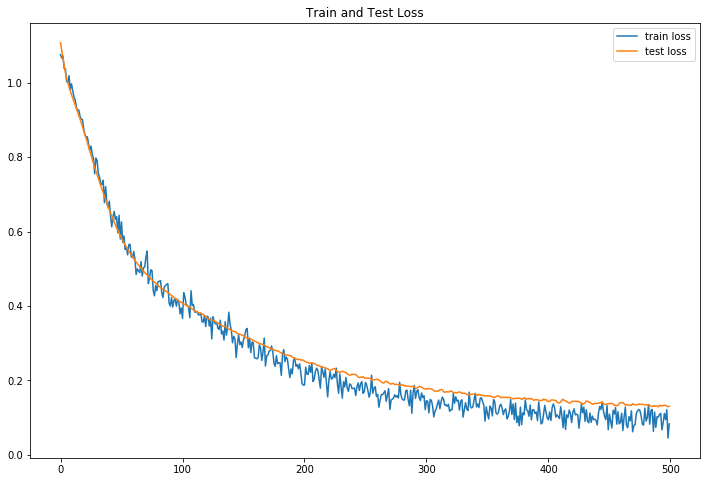

In [25]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

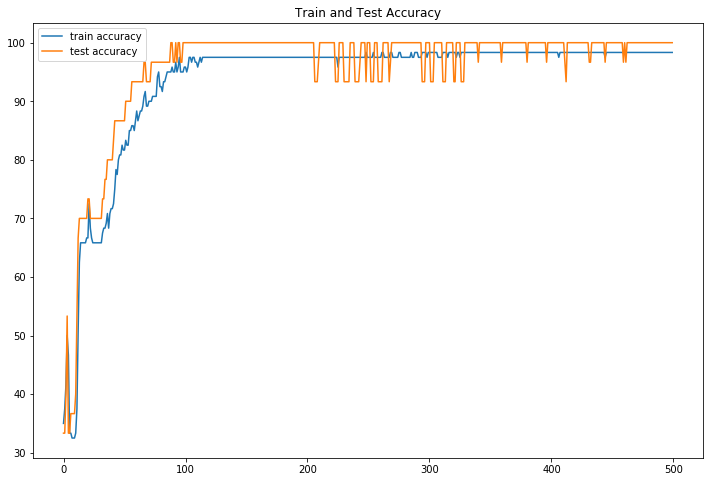

In [26]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

### Savign the model to disk, and loading it back

In [21]:
torch.save(net.state_dict(), "./2.model.pth")

In [22]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

In [23]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [24]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0
